<a href="https://colab.research.google.com/github/souvik3333/medium_blogs/blob/main/transforms/manifold_mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

In [1]:
# download and prepare the dataset
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -qq kagglecatsanddogs_3367a.zip

--2022-05-07 03:46:55--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.6.204.110, 2600:1407:f800:4a5::e59, 2600:1407:f800:49b::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.6.204.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.2’

kagglecatsanddogs_3 100%[===================>] 786.68M   111MB/s    in 7.3s    

2022-05-07 03:47:03 (108 MB/s) - ‘kagglecatsanddogs_3367a.zip.2’ saved [824894548/824894548]

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Create mix-up image

In [2]:
import numpy as np
from PIL import Image

In [3]:
def simple_image_mixup(image_1, image_2, alpha):
    new_image = (alpha * np.asarray(image_1)) + ((1-alpha) * np.asarray(image_2))

    return np.uint8(new_image)

In [4]:
import matplotlib.pyplot as plt

In [5]:
def plot_mixup_images(image_1, image_2, new_image):
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(image_1)
    plt.title("image_1")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(image_2)
    plt.title("image_2")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(new_image)
    plt.title("new_image")
    plt.axis('off')
    plt.show()

In [6]:
# select two images and create mixup image
image_1_path = "/content/PetImages/Cat/0.jpg"
image_2_path = "/content/PetImages/Dog/0.jpg"
image_1 = plt.imread(image_1_path)
image_2 = plt.imread(image_2_path)

In [7]:
# get the mixup image
new_image = simple_image_mixup(image_1=image_1, image_2=image_2, alpha=0.4)

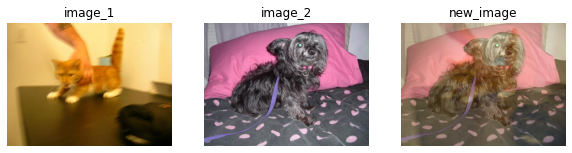

In [8]:
plot_mixup_images(image_1, image_2, new_image)

## Input Mixup with a classifier on CIFAR10 dataset

### Input mixup utils

In [9]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, targets, and lambda
    Args:
    -----
    x: input data
    y: target
    alpha: value of alpha and beta in beta distribution 
    '''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size) # shuffle index

    mixed_x = lam * x + (1 - lam) * x[index, :] # mixup between original image order and shuffled image order
    y_a, y_b = y, y[index] # return target of both images order
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """ Updated loss for mixup.
    Args:
    -----
    criterion: loss function to use, example: crossentropy loss
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def mixup_accuracy(metric, preds, y_a, y_b, lam):
    """
    Updated metric calculation:
    Args:
    -----
    metric: metric to use, example: accuracy
    preds: predictions from network
    y_a: original labels
    y_b: labels of the shuffled batch
    lam: alpha used for mixup
    """

    return lam * metric(preds, y_a) + (1 - lam) * metric(preds, y_b)

In [10]:
# install lightning and timm(pytorch image models) for training classifier
! pip install timm pytorch_lightning -qq

### Training model

In [11]:
import timm
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.autograd import Variable
import torchmetrics

seed_everything(42, workers=True) # must do for distributed training

Global seed set to 42


42

In [12]:
class Model(pl.LightningModule):
    """
    Lightning model
    """
    def __init__(self, model_name, num_classes, lr = 0.001, max_iter=20, mix_up=False, alpha=1):
        """Model trainer class
        Parameters
        ----------
        model_name: Name of the timm model
        num_classes: number of classes in the dataset
        lr: learning rate
        max_iter: maximum iterations
        mix_up: use mixup augmentation or not
        alpha: alpha for beta distribution in mixup
        """
        super().__init__()
        # setup the model
        self.num_classes = num_classes
        self.model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_classes)
        # setup accuracy metric
        self.metric = torchmetrics.functional.accuracy
        # setup cross entropy loss function 
        self.loss = torch.nn.CrossEntropyLoss()
        self.lr = lr
        self.max_iter = max_iter
        self.mix_up = mix_up
        self.alpha = alpha 

    def forward(self, x):
        return self.model(x)
        
    def shared_step(self, batch, batch_idx, is_train=False):
        x, y = batch
        if is_train and self.mix_up: # if mixup is true and train
            # prepare the mixup date
            x, y_a, y_b, lam = mixup_data(x, y, self.alpha)
            x, y_a, y_b = map(Variable, (x, y_a, y_b))
            # pass the new data through model
            logits = self(x)
            # calculate loss
            loss = mixup_criterion(self.loss, logits, y_a, y_b, lam)
            # calculate accuracy
            preds = torch.argmax(logits, dim=1)
            acc = mixup_accuracy(self.metric, preds, y_a, y_b, lam)
        else: # if mixup is false or validation
            # no change in data, we padd the batch data as is
            # pass the data through model
            logits = self(x)
            # calculate loss
            loss = self.loss(logits, y)
            # calculate accuracy
            preds = torch.argmax(logits, dim=1)
            acc = self.metric(preds, y)
        
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx, is_train=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, logger=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx, is_train=False)
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, logger=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim, T_max=self.max_iter)
        
        return [optim], [scheduler]

### Transforms and datasets and dataloaders

In [13]:
# standard image transform for classifier
transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# batch size, reduce if cuda out of memory (should work fine in colab with gpu)
batch_size = 128
# get cifar-10 train set
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# split train-full set 
# used trainset have 20000
trainset, trainset_remains = torch.utils.data.random_split(trainset_full, [20000, len(trainset_full)-20000])
# create train dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# val dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# classes in cifar 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Checkpoint callback and trainer setup without mixup

In [14]:
model = Model(model_name="resnet18", num_classes=len(classes), lr = 0.001, max_iter=20, mix_up=False)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',
    filename='resnet_18_org-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}'
)
trainer = Trainer(
    deterministic=True, 
    logger=True, 
    callbacks=[checkpoint_callback], 
    gpus=[0], # change it based on gpu or cpu availability
    max_epochs=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training without mixup

In [ ]:
trainer.fit(model=model, train_dataloaders=trainloader, val_dataloaders=testloader)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Checkpoint callback and trainer setup with mixup

In [ ]:
model = Model(model_name="resnet18", num_classes=len(classes), lr = 0.001, max_iter=20, mix_up=True, alpha=1)
checkpoint_callback_mixup = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',
    filename='resnet_18_mixup-cifar10-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}'
)
trainer = Trainer(
    deterministic=True, 
    logger=True, 
    callbacks=[checkpoint_callback_mixup], 
    gpus=[0], # change it based on gpu or cpu availability
    max_epochs=5)

### Training with mixup

In [ ]:
trainer.fit(model=model, train_dataloaders=trainloader, val_dataloaders=testloader)

## Manifold mixup

### Update the ResNet18 model to support manifold mixup

In [ ]:
class Resnet18MM(nn.Module):
    def __init__(self, model_name, classes, pretrained=False, alpha=1.0):
        super().__init__()
        model = timm.create_model(model_name=model_name, pretrained=pretrained, num_classes=classes)
        self.model_list = Resnet18MM._model_setup(model)
        self.num_model = len(self.model_list)
        self.alpha = alpha

    @staticmethod
    def _model_setup(model):
        model_list = []
        count=0
        d = [] # start and end index of the layer blocks
        start_index = 0
        for index, layer in enumerate(model.children()): # check all the layers of the model
            count+=1
            if isinstance(layer, nn.Sequential): # if it is nn.Sequential then update the list d with start and end index
                d.append((start_index, count-1)) 
                start_index = count-1
        
        d.append((start_index, len(list(model.children())))) # append any remaining layers
        module_blocks = [ 
                nn.Sequential(*list(model.children())[index[0]: index[1]]) for index in d
        ] # insert each module blocks into a list, blocks are created based on the start and end index of each block
        
        return nn.ModuleList(module_blocks) # return the list as ModuleList
    
    def _forward(self, x, i=0, j=None):
        assert i>=0 # make sure start index is >=0
        assert j is None or j<=len(self.model_list)-1 # max end index is num of blocks - 1
        assert j is None or i<=j # start index is < the end index
        if j is None: # if j is None pass till the end block
            j = len(self.model_list)

        for model_layer in self.model_list[i:j]:
            x = model_layer(x)

        return x
    
    def forward(self, x, mixup=False):
        index = None
        lam = None
        if mixup:
            k = np.random.randint(0, self.num_model) # select a random intermediate layer to mixup the o/p
            batch_size = x.size()[0]
            index = torch.randperm(batch_size) # shuffle index
            lam = np.random.beta(self.alpha, self.alpha) # select alpha randomly 
            if hasattr(self, "log"): # logging
                self.log("k", k, on_step=True, on_epoch=False, logger=True, prog_bar=True)
                self.log("lam", lam, on_step=True, on_epoch=False, logger=True, prog_bar=True)
            op_int = lam * self._forward(x, i=0, j=k) + (1 - lam) * self._forward(x[index, :], i=0, j=k) # mixup the op of k the layer
            op = self._forward(op_int, i=k, j=None) # pass the mixup remaining layers
        else: # if not mixup pass through all model blocks
            op = self._forward(x, i=0, j=None) 

        return op, index, lam # return model output, shuffle order, lambda

In [ ]:
class ModelMM(pl.LightningModule):
    """
    Lightning model
    """
    def __init__(self, mixup_model, num_classes, lr = 0.001, max_iter=20, mix_up=False, alpha=1):
        """Model trainer class for manifold mixup
        Parameters
        ----------
        mixup_model: mixup model
        num_classes: number of classes in the dataset
        lr: learning rate
        max_iter: maximum iterations
        mix_up: use mixup augmentation or not
        alpha: alpha for beta distribution in mixup
        """
        super().__init__()
        # setup the model
        self.num_classes = num_classes
        self.model = mixup_model
        # setup accuracy metric
        self.metric = torchmetrics.functional.accuracy
        # setup cross entropy loss function 
        self.loss = torch.nn.CrossEntropyLoss()
        self.lr = lr
        self.max_iter = max_iter
        self.mix_up = mix_up
        self.alpha = alpha 

    def forward(self, x, mixup=False):
        return self.model(x, mixup)
        
    def shared_step(self, batch, batch_idx, is_train=False):
        x, y = batch
        if is_train and self.mix_up:
            logits, index, lam = self(x, True)
            y_a, y_b = y, y[index] 

            # # x, y_a, y_b, lam = mixup_data(x, y, self.alpha)
            # # x, y_a, y_b = map(Variable, (x, y_a, y_b))
            # logits = self(x)
            loss = mixup_criterion(self.loss, logits, y_a, y_b, lam)
            preds = torch.argmax(logits, dim=1)
            acc = mixup_accuracy(self.metric, preds, y_a, y_b, lam)
        else:
            logits, _, _ = self(x, False)
            loss = self.loss(logits, y)
            preds = torch.argmax(logits, dim=1)
            acc = self.metric(preds, y)
        
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx, is_train=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, logger=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx, is_train=False)
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, logger=True, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optim, T_max=self.max_iter)
        
        return [optim], [scheduler]

In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize(224),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# batch_size = 128
# trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# trainset, trainset_remains = torch.utils.data.random_split(trainset_full, [20000, len(trainset_full)-20000])
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
resnet_18mm = Resnet18MM(model_name="resnet18", classes=10, pretrained=True)

model = ModelMM(mixup_model=resnet_18mm, num_classes=len(classes), lr = 0.001, max_iter=20, mix_up=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',
    filename='resnet18-manifold-mixup-cifar10-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}'
)
trainer = Trainer(
    deterministic=True, 
    logger=True, 
    callbacks=[checkpoint_callback], 
    gpus=[0], # change it based on gpu or cpu availability
    max_epochs=5)

In [ ]:
trainer.fit(model=model, train_dataloaders=trainloader, val_dataloaders=testloader)